import libraries and read data

In [1]:
# we have to install the development version for the time being
#!pip uninstall eodal -y
#!pip install git+https://github.com/lukasValentin/eodal@landsat-dev

#!pip install --upgrade git+https://github.com/EOA-team/eodal
#!pip install --upgrade planetary-computer

# Print EOdal version
#import eodal
#print("Version of EOdal: " + eodal.__version__)

In [2]:
# Import general libraries
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

# Import EOdal libraries
from eodal.core.band import Band
from eodal.core.raster import RasterCollection

# Import scikit-learn libraries
import sklearn
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import pairwise_distances
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler

In [3]:
#year to cluster
year = 2021

In [4]:
#read tif from disk:
fpath_raster = Path(f'S:\MSc_23_TimckeFinn\data\EOdal\landsat_median_composite_{year}.tif')

# initialize a RasterCollection from the .tif file
composite = RasterCollection.from_multi_band_raster(fpath_raster=fpath_raster,
                                                    band_names_dst= ['blue_median','green_median','red_median','nir08_median','swir16_median','swir22_median'],
                                                    band_aliases = ["blue", "green", "red", "nir_1", "swir_1","swir_2"])

# print band summaries
composite.band_summaries()

# calculate some SI
composite.calc_si('NDVI', inplace = True)
composite.calc_si('NDWI', inplace = True)
composite.calc_si('EVI', inplace = True)
composite.calc_si('CI_GREEN', inplace = True)
composite.calc_si('MSAVI', inplace = True)
composite.calc_si('BSI', inplace = True)



In [5]:
composite

EOdal RasterCollection
----------------------
# Bands:    12
Band names:    blue_median, green_median, red_median, nir08_median, swir16_median, swir22_median, NDVI, NDWI, EVI, CI_GREEN, MSAVI, BSI
Band aliases:    blue, green, red, nir_1, swir_1, swir_2, ndvi, ndwi, evi, ci_green, msavi, bsi

In [6]:
# Create a DataFrame from the RasterCollection
gdf = composite.to_dataframe()

gdf.head()

,geometry,blue_median,green_median,red_median,nir08_median,swir16_median,swir22_median,NDVI,NDWI,EVI,CI_GREEN,MSAVI,BSI
0,POINT (845041.112 99725.143),1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000
1,POINT (845041.112 99695.122),8.052000e-02,9.200000e-02,8.433000e-02,1.839900e-01,1.248800e-01,9.432000e-02,0.371422,-0.333309,0.229405,0.999891,0.165799,-0.116736
2,POINT (845041.112 99665.100),8.171500e-02,9.407500e-02,8.585000e-02,1.950700e-01,1.335850e-01,9.844000e-02,0.388794,-0.349288,0.248836,1.073558,0.180597,-0.115574
3,POINT (845041.112 99635.078),8.180000e-02,9.379000e-02,8.606000e-02,1.941400e-01,1.324200e-01,9.830000e-02,0.385724,-0.348522,0.246308,1.069943,0.178708,-0.116217
4,POINT (845041.112 99605.056),8.168000e-02,9.255000e-02,8.532000e-02,1.966400e-01,1.296000e-01,9.607000e-02,0.394808,-0.359936,0.253933,1.124689,0.184129,-0.128538


In [7]:
from sklearn.preprocessing import MinMaxScaler

selected_columns = ['blue_median','green_median','red_median','nir08_median','swir16_median','swir22_median','NDVI','NDWI','EVI','CI_GREEN','MSAVI','BSI']

## Step 1: Extract the feature columns from the GeoDataFrame into a NumPy array
features = gdf[selected_columns].values

## Step 2: Initialize the MinMaxScaler
scaler = MinMaxScaler()

## Step 3: Fit the scaler to the feature data
scaler.fit(features)

## Step 4: Transform the feature data using the fitted scaler
scaled_features = scaler.transform(features)

## Step 5: Replace the original feature values in the GeoDataFrame with the scaled values
gdf[selected_columns] = scaled_features

gdf[selected_columns].head()

,blue_median,green_median,red_median,nir08_median,swir16_median,swir22_median,NDVI,NDWI,EVI,CI_GREEN,MSAVI,BSI
0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.009437,0.971428,0.005676,0.013921,0.005222,0.597719
1,6.755000e-23,1.319500e-22,8.690000e-23,9.642000e-22,4.606500e-22,1.872500e-22,0.668098,0.340010,0.521064,0.482311,0.491431,0.311236
2,7.950001e-23,1.527000e-22,1.021000e-22,1.075000e-21,5.477000e-22,2.284500e-22,0.698904,0.309739,0.564719,0.516820,0.534828,0.314087
3,8.035000e-23,1.498500e-22,1.042000e-22,1.065700e-21,5.360500e-22,2.270500e-22,0.693461,0.311191,0.559039,0.515127,0.529287,0.312509
4,7.915000e-23,1.374500e-22,9.680000e-23,1.090700e-21,5.078500e-22,2.047500e-22,0.709569,0.289568,0.576169,0.540772,0.545186,0.282272


In [8]:
# Get the colors from the "Accent" colormap
cmap = plt.get_cmap('Accent')
colors = cmap.colors
values = np.arange(8)

c:\Users\ftimcke\AppData\Local\anaconda3\envs\lulc\Lib\site-packages\eodal\core\band.py:1637: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.set_ticklabels(user_defined_ticks)


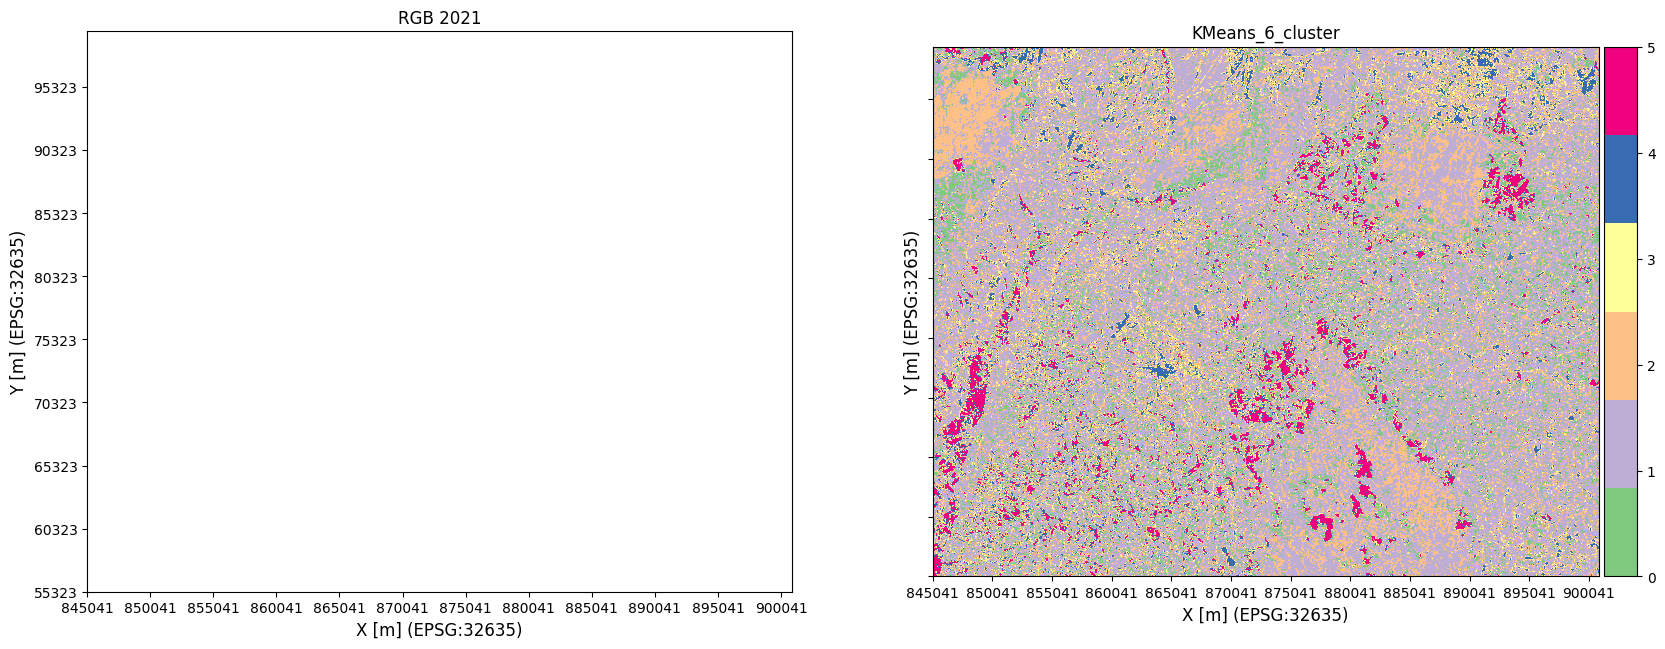

In [9]:
## Use K-means for Clustering:

# set the desired number of clusters for KMean and GMM

for n in range(6, 7, 1):

    # create model
    km = KMeans(n_clusters = n, n_init = 'auto') 

    # fit the model to the data
    km.fit(scaled_features)

    # Get the cluster labels
    labels = km.labels_

    # Calculate the scores
    #silhouette = silhouette_score(scaled_features, labels)
    #calinski_harabasz = calinski_harabasz_score(scaled_features, labels)
    #davies_bouldin = davies_bouldin_score(scaled_features, labels)

    # Print the scores
    #print(f'kmeans, {n}, Silhouette score, {silhouette}')
    #print(f'kmeans, {n}, Calinski-Harabasz score, {calinski_harabasz}')
    #print(f'kmeans, {n}, Davies-Bouldin score, {davies_bouldin}')

    # Add the cluster labels to the DataFrame and show it
    gdf[f'KMeans_{n}_cluster'] = labels
        
    # create new band instance from a column in GeoDataFrame
    KMeans_cluster = Band.from_vector(vector_features = gdf,
                                 band_name_src = f'KMeans_{n}_cluster',
                                 geo_info = composite['blue'].geo_info,
                                 band_name_dst = f'KMeans_{n}_cluster'
                                 )

    #add column KMeans_cluster as a new Band into the RasterCollection composite
    composite.add_band(KMeans_cluster)
    
    #plot clusters
    fig, axs = plt.subplots(1, 2, figsize = (20, 10), sharey=True)
    cmap = plt.cm.colors.ListedColormap(colors[:n])
    ticks = list(range(n))

    composite.plot_multiple_bands(["red", "green", "blue"], ax=axs[0])
    axs[0].set_title(f'RGB {year}')

    composite.plot_band(f'KMeans_{n}_cluster', colormap=cmap, discrete_values = False, user_defined_ticks = ticks, ax=axs[1])
    axs[1].set_title(f'KMeans_{n}_cluster')
    
    #save as PNG for quick view
    fig.savefig(f'S:\MSc_23_TimckeFinn\data\python_outputs\cluster\KMeans_{n}_cluster_{year}.png')


In [10]:
""" ## Use Spectral Clustering for Clustering:

from sklearn.cluster import SpectralClustering

for n in range(6, 7, 1):
    
    # Assuming 'scaled_features' is your scaled data array
    # You need to set the appropriate values for these parameters
    n_clusters = n  # Number of clusters you want to find
    affinity_matrix = 'nearest_neighbors'  # Type of affinity matrix ('nearest_neighbors' or 'rbf')
    random_state = 42  # Random state for reproducibility

    # Create a SpectralClustering instance
    spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity=affinity_matrix, random_state=random_state)

    # Fit and predict the clusters
    cluster_labels = spectral_clustering.fit_predict(scaled_features)

    print("Cluster labels:", cluster_labels)

    # Assign cluster labels to GeoDataFrame
    gdf[f'Spectral_{n_clusters}_cluster'] = cluster_labels

    # create new band instance from a column in GeoDataFrame
    Spectral_cluster = Band.from_vector(vector_features = gdf,
                                    band_name_src = f'Spectral_{n_clusters}_cluster',
                                    geo_info = composite['blue'].geo_info,
                                    band_name_dst = f'Spectral_{n_clusters}_cluster')

    #add column GMM_cluster as a new Band into the RasterCollection composite
    composite.add_band(Spectral_cluster)

    #plot clusters
    fig, axs = plt.subplots(1, 2, figsize = (20, 10), sharey=True)
    cmap = plt.cm.colors.ListedColormap(colors[:n_clusters])
    ticks = list(range(n_clusters))

    composite.plot_multiple_bands(["red", "green", "blue"], ax=axs[0])
    axs[0].set_title(f'RGB {year}')

    composite.plot_band(f'Spectral_{n_clusters}_cluster', colormap=cmap, discrete_values = False, user_defined_ticks = ticks, ax=axs[1])
    axs[1].set_title(f'Spectral_{n_clusters}_cluster')

    #save as PNG for quick view
    fig.savefig(f'S:\MSc_23_TimckeFinn\data\python_outputs\cluster\Spectral_{n_clusters}_cluster_{year}.png') """

' ## Use Spectral Clustering for Clustering:\n\nfrom sklearn.cluster import SpectralClustering\n\nfor n in range(6, 7, 1):\n    \n    # Assuming \'scaled_features\' is your scaled data array\n    # You need to set the appropriate values for these parameters\n    n_clusters = n  # Number of clusters you want to find\n    affinity_matrix = \'nearest_neighbors\'  # Type of affinity matrix (\'nearest_neighbors\' or \'rbf\')\n    random_state = 42  # Random state for reproducibility\n\n    # Create a SpectralClustering instance\n    spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity=affinity_matrix, random_state=random_state)\n\n    # Fit and predict the clusters\n    cluster_labels = spectral_clustering.fit_predict(scaled_features)\n\n    print("Cluster labels:", cluster_labels)\n\n    # Assign cluster labels to GeoDataFrame\n    gdf[f\'Spectral_{n_clusters}_cluster\'] = cluster_labels\n\n    # create new band instance from a column in GeoDataFrame\n    Spectral_clust

In [11]:
""" ## Use Gaussian Mixture Models for Clustering:

for n in range(3, 7, 1):

    # create model
    gmm = GaussianMixture(n_components = n)

    # fit the model to the data
    gmm.fit(scaled_features)

    # Assign cluster labels
    GMM_cluster = gmm.predict(scaled_features)

    # Calculate the scores
    #silhouette = silhouette_score(scaled_features, labels)
    #calinski_harabasz = calinski_harabasz_score(scaled_features, labels)
    #davies_bouldin = davies_bouldin_score(scaled_features, labels)

    # Print the scores
    #print(f'gmm, {n}, Silhouette score, {silhouette}')
    #print(f'gmm, {n}, Calinski-Harabasz score, {calinski_harabasz}')
    #print(f'gmm, {n}, Davies-Bouldin score, {davies_bouldin}')

    # Assign cluster labels to GeoDataFrame
    gdf[f'GMM_{n}_cluster'] = GMM_cluster

    # create new band instance from a column in GeoDataFrame
    GMM_cluster = Band.from_vector(vector_features = gdf,
                                    band_name_src = f'GMM_{n}_cluster',
                                    geo_info = composite['blue'].geo_info,
                                    band_name_dst = f'GMM_{n}_cluster')

    #add column GMM_cluster as a new Band into the RasterCollection composite
    composite.add_band(GMM_cluster)
    
    #plot clusters
    fig, axs = plt.subplots(1, 2, figsize = (20, 10), sharey=True)
    cmap = plt.cm.colors.ListedColormap(colors[:n])
    ticks = list(range(n))

    composite.plot_multiple_bands(["red", "green", "blue"], ax=axs[0])
    axs[0].set_title(f'RGB {year}')

    composite.plot_band(f'GMM_{n}_cluster', colormap=cmap, discrete_values = False, user_defined_ticks = ticks, ax=axs[1])
    axs[1].set_title(f'GMM_{n}_cluster')
    
    #save as PNG for quick view
    fig.savefig(f'S:\MSc_23_TimckeFinn\data\python_outputs\cluster\GMM_{n}_cluster_{year}.png') """

' ## Use Gaussian Mixture Models for Clustering:\n\nfor n in range(3, 7, 1):\n\n    # create model\n    gmm = GaussianMixture(n_components = n)\n\n    # fit the model to the data\n    gmm.fit(scaled_features)\n\n    # Assign cluster labels\n    GMM_cluster = gmm.predict(scaled_features)\n\n    # Calculate the scores\n    #silhouette = silhouette_score(scaled_features, labels)\n    #calinski_harabasz = calinski_harabasz_score(scaled_features, labels)\n    #davies_bouldin = davies_bouldin_score(scaled_features, labels)\n\n    # Print the scores\n    #print(f\'gmm, {n}, Silhouette score, {silhouette}\')\n    #print(f\'gmm, {n}, Calinski-Harabasz score, {calinski_harabasz}\')\n    #print(f\'gmm, {n}, Davies-Bouldin score, {davies_bouldin}\')\n\n    # Assign cluster labels to GeoDataFrame\n    gdf[f\'GMM_{n}_cluster\'] = GMM_cluster\n\n    # create new band instance from a column in GeoDataFrame\n    GMM_cluster = Band.from_vector(vector_features = gdf,\n                                    

In [12]:
""" ## Use MeanShift for Clustering:
from sklearn.cluster import estimate_bandwidth

bandwidth_est = estimate_bandwidth(scaled_features)
print(f'estimated bandwidth: {bandwidth_est}')

#define bandwidth for model
bandwidth = 0.3

# create model
ms = MeanShift(bandwidth=bandwidth)

# fit the model to the data
ms.fit(scaled_features)

# Assign cluster labels
cluster_labels = ms.labels_

# Assign cluster labels to GeoDataFrame
gdf[f'MeanShift_cluster_{bandwidth}'] = cluster_labels

# add column cluster_mean_shift as a new Band into the RasterCollection composite
MeanShift_cluster = Band.from_vector(vector_features = gdf,
                                band_name_src = f'MeanShift_cluster_{bandwidth}',
                                geo_info = composite['blue'].geo_info,
                                band_name_dst=f'MeanShift_cluster_{bandwidth}')

#composite.add_band(MeanShift_cluster)

#plot clusters
fig, axs = plt.subplots(1, 2, figsize = (20, 10), sharey=True)

composite.plot_multiple_bands(["red", "green", "blue"], ax=axs[0])
axs[0].set_title(f'RGB {year}')

composite.plot_band(f'MeanShift_cluster_{bandwidth}', colormap='Accent', discrete_values = False, user_defined_ticks = ticks, ax=axs[1])
axs[1].set_title(f'MeanShift_cluster with bandwith: {bandwidth}')

#save as PNG for quick view
fig.savefig(f'S:\MSc_23_TimckeFinn\data\python_outputs\cluster\MS_cluster_{year}_{bandwidth}.png')
 """

' ## Use MeanShift for Clustering:\nfrom sklearn.cluster import estimate_bandwidth\n\nbandwidth_est = estimate_bandwidth(scaled_features)\nprint(f\'estimated bandwidth: {bandwidth_est}\')\n\n#define bandwidth for model\nbandwidth = 0.3\n\n# create model\nms = MeanShift(bandwidth=bandwidth)\n\n# fit the model to the data\nms.fit(scaled_features)\n\n# Assign cluster labels\ncluster_labels = ms.labels_\n\n# Assign cluster labels to GeoDataFrame\ngdf[f\'MeanShift_cluster_{bandwidth}\'] = cluster_labels\n\n# add column cluster_mean_shift as a new Band into the RasterCollection composite\nMeanShift_cluster = Band.from_vector(vector_features = gdf,\n                                band_name_src = f\'MeanShift_cluster_{bandwidth}\',\n                                geo_info = composite[\'blue\'].geo_info,\n                                band_name_dst=f\'MeanShift_cluster_{bandwidth}\')\n\n#composite.add_band(MeanShift_cluster)\n\n#plot clusters\nfig, axs = plt.subplots(1, 2, figsize = (20, 10

In [13]:
composite.band_summaries()

,min,mean,std,max,count,geometry,band_name
0,0.073765,5.314547e+16,2.304717e+18,1.000000e+20,2750940.0,"POLYGON ((900881.573 55322.971, 900881.573 997...",blue_median
1,0.078805,5.314547e+16,2.304717e+18,1.000000e+20,2750940.0,"POLYGON ((900881.573 55322.971, 900881.573 997...",green_median
2,0.075640,5.314547e+16,2.304717e+18,1.000000e+20,2750940.0,"POLYGON ((900881.573 55322.971, 900881.573 997...",red_median
3,0.087570,5.314547e+16,2.304717e+18,1.000000e+20,2750940.0,"POLYGON ((900881.573 55322.971, 900881.573 997...",nir08_median
4,0.078815,5.314547e+16,2.304717e+18,1.000000e+20,2750940.0,"POLYGON ((900881.573 55322.971, 900881.573 997...",swir16_median
5,0.075595,5.314547e+16,2.304717e+18,1.000000e+20,2750940.0,"POLYGON ((900881.573 55322.971, 900881.573 997...",swir22_median
6,-0.005322,3.617677e-01,4.134730e-02,5.585834e-01,2750940.0,"POLYGON ((900881.573 55322.971, 900881.573 997...",NDVI
7,-0.512792,-3.363444e-01,3.568442e-02,1.508254e-02,2750940.0,"POLYGON ((900881.573 55322.971, 900881.573 997...",NDWI
8,-0.002527,2.280287e-01,3.412661e-02,4.425848e-01,2750940.0,"POLYGON ((900881.573 55322.971, 900881.573 997...",EVI
9,-0.029717,1.021967e+00,1.567559e-01,2.105021e+00,2750940.0,"POLYGON ((900881.573 55322.971, 900881.573 997...",CI_GREEN


In [14]:
composite.drop_band(band_name=)

# save as GeoTiff
composite.to_rasterio(f'S:\MSc_23_TimckeFinn\data\EOdal\landsat_median_composite_{year}_clean_si_cluster.tif')

SyntaxError: invalid syntax (3759425774.py, line 1)